In [1]:
from urllib.request import urlopen
from zipfile import ZipFile
import os

import re
import cv2
import pickle
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import models
from scipy.spatial.transform import Rotation as R

## Helper Functions

In [3]:
from Helper import *
from ground_truth import create_GT_masks
from UV_mapping import create_UV_XYZ_dictionary
from LineMOD import LineMODDataset
from PoseRefinement import PoseRefinerDataset

In [8]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler


In [9]:
def train_correspondence_block(root_dir, classes, epochs=20, batch_size = 3):

    train_data = LineMODDataset(root_dir, classes=classes,
                                transform=transforms.Compose([transforms.ToTensor(),
                                transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)]))

    
    num_workers = 0
    valid_size = 0.2
    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               sampler=valid_sampler, num_workers=num_workers)

    # architecture for correspondence block - 13 objects + backgound = 14 channels for ID masks
    correspondence_block = UNet(
        n_channels=3, out_channels_id=14, out_channels_uv=256, bilinear=True)
    correspondence_block.cuda()

    # custom loss function and optimizer
    criterion_id = nn.CrossEntropyLoss()
    criterion_u = nn.CrossEntropyLoss()
    criterion_v = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = optim.Adam(
        correspondence_block.parameters(), lr=3e-4, weight_decay=3e-5)

    # training loop

    # number of epochs to train the model
    n_epochs = epochs

    valid_loss_min = np.Inf  # track change in validation loss
    
    correspondance_train_loss_history = [] # track correspondance loss history
    correspondance_valid_loss_history = []
    
    for epoch in range(1, n_epochs+1):
        torch.cuda.empty_cache()
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print("------ Epoch ", epoch, " ---------")

        ###################
        # train the model #
        ###################
        correspondence_block.train()
        for _, image, idmask, umask, vmask in train_loader:
            # move tensors to GPU if CUDA is available
            image, idmask, umask, vmask = image.cuda(
            ), idmask.cuda(), umask.cuda(), vmask.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            idmask_pred, umask_pred, vmask_pred = correspondence_block(image)
            # calculate the batch loss
            loss_id = criterion_id(idmask_pred, idmask)
            loss_u = criterion_u(umask_pred, umask)
            loss_v = criterion_v(vmask_pred, vmask)
            loss = loss_id + loss_u + loss_v
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()
        ######################
        # validate the model #
        ######################
        correspondence_block.eval()
        for _, image, idmask, umask, vmask in valid_loader:
            # move tensors to GPU if CUDA is available
            image, idmask, umask, vmask = image.cuda(
            ), idmask.cuda(), umask.cuda(), vmask.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            idmask_pred, umask_pred, vmask_pred = correspondence_block(image)
            # calculate the batch loss
            loss_id = criterion_id(idmask_pred, idmask)
            loss_u = criterion_u(umask_pred, umask)
            loss_v = criterion_v(vmask_pred, vmask)
            loss = loss_id + loss_u + loss_v
            # update average validation loss
            valid_loss += loss.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        correspondance_train_loss_history.append(train_loss)
        correspondance_valid_loss_history.append(valid_loss)
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(correspondence_block.state_dict(),
                       'correspondence_block.pt')
            valid_loss_min = valid_loss
    
    print("correspondance_train_loss_history", correspondance_train_loss_history)
    print("correspondance_valid_loss_history", correspondance_valid_loss_history)
    plt.style.use('ggplot')
    plt.plot(correspondance_train_loss_history, label = "Training Loss")
    plt.plot(correspondance_valid_loss_history, label = "Validation Loss")
    plt.legend()
    plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upscaling then double conv
    """

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels // 2, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
        
class UNet(nn.Module):
    def __init__(self, n_channels = 3, out_channels_id = 9, out_channels_uv = 256, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.out_channels_id = out_channels_id
        self.out_channels_uv = out_channels_uv
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)


        #ID MASK
        self.up1_id = Up(1024, 512, bilinear)
        self.up2_id = Up(512, 256, bilinear)
        self.up3_id = Up(256, 128, bilinear)
        self.up4_id = Up(128, 64 * factor, bilinear)
        self.outc_id = OutConv(64, out_channels_id)

        #U Mask
        self.up1_u = Up(1024, 512, bilinear)
        self.up2_u = Up(512,512,bilinear)
        self.outc_u1 = OutConv(256, out_channels_uv)
        self.outc_u2 = OutConv(256, out_channels_uv)
        self.outc_u3 = OutConv(256, out_channels_uv)
        self.outc_u4 = OutConv(256, out_channels_uv)
        self.up3_u = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up4_u = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        #V Mask
        self.up1_v = Up(1024, 512, bilinear)
        self.up2_v = Up(512,512,bilinear)
        self.outc_v1 = OutConv(256, out_channels_uv)
        self.outc_v2 = OutConv(256, out_channels_uv)
        self.outc_v3 = OutConv(256, out_channels_uv)
        self.outc_v4 = OutConv(256, out_channels_uv)
        self.up3_v = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up4_v = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # ID mask
        x_id = self.up1_id(x5, x4)
        x_id = self.up2_id(x_id, x3)
        x_id = self.up3_id(x_id, x2)
        x_id = self.up4_id(x_id, x1)
        logits_id = self.outc_id(x_id)

        # U mask
        x_u = self.up1_u(x5, x4)
        x_u = self.up2_u(x_u,x3)
        x_u = self.outc_u1(x_u)
        x_u = self.outc_u2(x_u)
        x_u = self.outc_u3(x_u)
        x_u = self.up3_u(x_u)
        x_u = self.up4_u(x_u)
        logits_u = self.outc_u4(x_u)

        # V mask
        x_v = self.up1_v(x5, x4)
        x_v = self.up2_v(x_v,x3)
        x_v = self.outc_v1(x_v)
        x_v = self.outc_v2(x_v)
        x_v = self.outc_v3(x_v)
        x_v = self.up3_v(x_v)
        x_v = self.up4_v(x_v)
        logits_v = self.outc_v4(x_v)
        
        return logits_id,logits_u, logits_v

In [11]:
def initial_pose_estimation(root_dir, classes, intrinsic_matrix):

    # LineMOD Dataset
    train_data = LineMODDataset(root_dir, classes=classes,
                                transform=transforms.Compose([transforms.ToTensor()]))

    # load the best correspondence block weights
    correspondence_block = UNet(
        n_channels=3, out_channels_id=14, out_channels_uv=256, bilinear=True)
    correspondence_block.cuda()
    correspondence_block.load_state_dict(torch.load(
        'correspondence_block.pt', map_location=torch.device('cpu')))

    # initial 6D pose prediction
    regex = re.compile(r'\d+')
    outliers = 0
    for i in range(len(train_data)):
        if i % 1000 == 0:
            print(str(i) + "/" + str(len(train_data)) + " finished!")
        img_adr, img, idmask, _, _ = train_data[i]
        label = os.path.split(os.path.split(os.path.dirname(img_adr))[0])[1]
        idx = regex.findall(os.path.split(img_adr)[1])[0]
        img = img.view(1, img.shape[0], img.shape[1], img.shape[2])
        idmask_pred, umask_pred, vmask_pred = correspondence_block(img.cuda())
        # convert the masks to 240,320 shape
        temp = torch.argmax(idmask_pred, dim=1).squeeze().cpu()
        upred = torch.argmax(umask_pred, dim=1).squeeze().cpu()
        vpred = torch.argmax(vmask_pred, dim=1).squeeze().cpu()
        coord_2d = (temp == classes[label]).nonzero(as_tuple=True)

        adr = root_dir + label + "/predicted_pose/" + \
            "info_" + str(idx) + ".txt"

        coord_2d = torch.cat((coord_2d[0].view(
            coord_2d[0].shape[0], 1), coord_2d[1].view(coord_2d[1].shape[0], 1)), 1)
        uvalues = upred[coord_2d[:, 0], coord_2d[:, 1]]
        vvalues = vpred[coord_2d[:, 0], coord_2d[:, 1]]
        dct_keys = torch.cat((uvalues.view(-1, 1), vvalues.view(-1, 1)), 1)
        dct_keys = tuple(dct_keys.numpy())
        dct = load_obj(root_dir + label + "/UV-XYZ_mapping")
        mapping_2d = []
        mapping_3d = []
        for count, (u, v) in enumerate(dct_keys):
            if (u, v) in dct:
                mapping_2d.append(np.array(coord_2d[count]))
                mapping_3d.append(dct[(u, v)])
        # Get the 6D pose from rotation and translation matrices
        # PnP needs atleast 6 unique 2D-3D correspondences to run
        if len(mapping_2d) >= 4 or len(mapping_3d) >= 4:
            _, rvecs, tvecs, inliers = cv2.solvePnPRansac(np.array(mapping_3d, dtype=np.float32),
                                                          np.array(mapping_2d, dtype=np.float32), 
                                                          intrinsic_matrix, 
                                                          distCoeffs=None,
                                                          iterationsCount=150, 
                                                          reprojectionError=1.0, 
                                                          flags=cv2.SOLVEPNP_P3P)
            rot, _ = cv2.Rodrigues(rvecs, jacobian=None)
            rot[np.isnan(rot)] = 1
            tvecs[np.isnan(tvecs)] = 1
            tvecs = np.where(-100 < tvecs, tvecs, np.array([-100.]))
            tvecs = np.where(tvecs < 100, tvecs, np.array([100.]))
            rot_tra = np.append(rot, tvecs, axis=1)
            # save the predicted pose
            np.savetxt(adr, rot_tra)
        else:  # save a pose full of zeros
            outliers += 1
            rot_tra = np.ones((3, 4))
            rot_tra[:, 3] = 0
            np.savetxt(adr, rot_tra)
    print("Number of instances where PnP couldn't be used: ", outliers)

In [12]:
def create_refinement_inputs(root_dir, classes, intrinsic_matrix):
    correspondence_block = UNet(
        n_channels=3, out_channels_id=14, out_channels_uv=256, bilinear=True)
    correspondence_block.cuda()
    correspondence_block.load_state_dict(torch.load(
        'correspondence_block.pt', map_location=torch.device('cpu')))

    train_data = LineMODDataset(root_dir, 
                                classes=classes,
                                transform=transforms.Compose([transforms.ToTensor()]))

    upsampled = nn.Upsample(size=[240, 320], mode='bilinear',align_corners=False)

    regex = re.compile(r'\d+')
    count = 0
    
    for i in range(len(train_data)):
        if i % 1000 == 0:
            print(str(i) + "/" + str(len(train_data)) + " finished!")
        img_adr, img, _, _, _ = train_data[i]

        label = os.path.split(os.path.split(os.path.dirname(img_adr))[0])[1]
        idx = regex.findall(os.path.split(img_adr)[1])[0]
        adr_rendered = root_dir + label + \
            "/pose_refinement/rendered/color" + str(idx) + ".png"
        adr_img = root_dir + label + \
            "/pose_refinement/real/color" + str(idx) + ".png"
        # find the object in the image using the idmask
        img = img.view(1, img.shape[0], img.shape[1], img.shape[2])
        idmask_pred, _, _ = correspondence_block(img.cuda())
        idmask = torch.argmax(idmask_pred, dim=1).squeeze().cpu()
        coord_2d = (idmask == classes[label]).nonzero(as_tuple=True)
        if coord_2d[0].nelement() != 0:
            coord_2d = torch.cat((coord_2d[0].view(
                coord_2d[0].shape[0], 1), coord_2d[1].view(coord_2d[1].shape[0], 1)), 1)
            min_x = coord_2d[:, 0].min()
            max_x = coord_2d[:, 0].max()
            min_y = coord_2d[:, 1].min()
            max_y = coord_2d[:, 1].max()
            img = img.squeeze().transpose(1, 2).transpose(0, 2)
            obj_img = img[min_x:max_x+1, min_y:max_y+1, :]
            # saving in the correct format using upsampling
            obj_img = obj_img.transpose(0, 1).transpose(0, 2).unsqueeze(dim=0)
            obj_img = upsampled(obj_img)
            obj_img = obj_img.squeeze().transpose(0, 2).transpose(0, 1)
            mpimg.imsave(adr_img, obj_img.squeeze().numpy())

            # create rendering for an object
            cropped_rendered_image = create_rendering(
                root_dir, intrinsic_matrix, label, idx)
            rendered_img = torch.from_numpy(cropped_rendered_image)
            rendered_img = rendered_img.unsqueeze(dim=0)
            rendered_img = rendered_img.transpose(1, 3).transpose(2, 3)
            rendered_img = upsampled(rendered_img)
            rendered_img = rendered_img.squeeze().transpose(0, 2).transpose(0, 1)
            mpimg.imsave(adr_rendered, rendered_img.numpy())

        else:  # object not present in idmask prediction
            count += 1
            mpimg.imsave(adr_rendered, np.zeros((240, 320)))
            mpimg.imsave(adr_img, np.zeros((240, 320)))
    print("Number of outliers: ", count)

In [13]:
class Pose_Refiner(nn.Module):

    def __init__(self):
        super(Pose_Refiner, self).__init__()
        self.feature_extractor_image = nn.Sequential(*list(models.resnet18(pretrained=True,
                                                                           progress=True).children())[:9])
        self.feature_extractor_rendered = nn.Sequential(*list(models.resnet18(pretrained=True,
                                                                              progress=True).children())[:9])
        self.fc_xyhead_1 = nn.Linear(512, 253)
        self.fc_xyhead_2 = nn.Linear(256, 2)
        self.fc_zhead = nn.Sequential(nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Linear(256, 1))
        self.fc_Rhead_1 = nn.Linear(512, 252)
        self.fc_Rhead_2 = nn.Linear(256, 4)

        self.relu_layer = nn.ReLU()

    def _initialize_weights(self):
        # weight initialization
        nn.init.constant_(self.fc_xyhead_1.weight, 0.)
        nn.init.constant_(self.fc_xyhead_1.bias, 0.)

        weights = torch.zeros((2, 256))
        weights[0, 253] = torch.tensor(1.)
        weights[1, 254] = torch.tensor(1.)
        self.fc_xyhead_2.weight = nn.Parameter(weights)
        nn.init.constant_(self.fc_xyhead_2.bias, 0.)

        nn.init.constant_(self.fc_zhead.weight, 0.)
        nn.init.constant_(self.fc_zhead.bias, 0.)

        nn.init.constant_(self.fc_Rhead_1.weight, 0.)
        nn.init.constant_(self.fc_Rhead_1.bias, 0.)

        rand_weights = torch.zeros((4, 256))
        rand_weights[0, 252] = torch.tensor(1.)
        rand_weights[1, 253] = torch.tensor(1.)
        rand_weights[2, 254] = torch.tensor(1.)
        rand_weights[3, 255] = torch.tensor(1.)
        self.fc_Rhead_2.weight = nn.Parameter(weights)
        nn.init.constant_(self.fc_Rhead_2.bias, 0.)

    def forward(self, image, rendered, pred_pose, bs=1):
        # extracting the feature vector f
        f_image = self.feature_extractor_image(image)
        f_rendered = self.feature_extractor_rendered(rendered)
        f_image = f_image.view(bs, -1)
        f_image = self.relu_layer(f_image)
        f_rendered = f_rendered.view(bs, -1)
        f_rendered = self.relu_layer(f_rendered)
        f = f_image - f_rendered

        # Z refinement head
        z = self.fc_zhead(f)

        # XY refinement head
        f_xy1 = self.fc_xyhead_1(f)
        f_xy1 = self.relu_layer(f_xy1)
        x_pred = np.reshape(pred_pose[:, 0, 3], (bs, -1))
        y_pred = np.reshape(pred_pose[:, 1, 3], (bs, -1))
        f_xy1 = torch.cat((f_xy1, x_pred.float().cuda()), 1)
        f_xy1 = torch.cat((f_xy1, y_pred.float().cuda()), 1)
        f_xy1 = torch.cat((f_xy1, z), 1)
        xy = self.fc_xyhead_2(f_xy1.cuda())

        # Rotation head
        f_r1 = self.fc_Rhead_1(f)
        f_r1 = self.relu_layer(f_r1)
        r = R.from_matrix(pred_pose[:, 0:3, 0:3])
        r = r.as_quat()
        r = np.reshape(r, (bs, -1))
        f_r1 = torch.cat(
            (f_r1, torch.from_numpy(r).float().cuda()), 1)
        rot = self.fc_Rhead_2(f_r1)

        return xy, z, rot

In [15]:
def train_pose_refinement(root_dir, classes, epochs=5):
    
    train_data = PoseRefinerDataset(root_dir, classes=classes,
                                    transform=transforms.Compose([
                                        transforms.ToPILImage(mode=None),
                                        transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [
                                                             0.229, 0.224, 0.225]),
                                        transforms.ColorJitter(
                                            brightness=0, contrast=0, saturation=0, hue=0)
                                    ]))

    pose_refiner = Pose_Refiner()
    pose_refiner.cuda()
    # freeze resnet
    # pose_refiner.feature_extractor[0].weight.requires_grad = False

    batch_size = 2
    num_workers = 0
    valid_size = 0.2
    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               sampler=valid_sampler, num_workers=num_workers)

    optimizer = optim.Adam(pose_refiner.parameters(),
                           lr=1.5e-4, weight_decay=3e-5)

    # number of epochs to train the model
    n_epochs = epochs

    valid_loss_min = np.Inf  # track change in validation loss
    for epoch in range(1, n_epochs+1):
        torch.cuda.empty_cache()
        print("----- Epoch Number: ", epoch, "--------")

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        pose_refiner.train()
        for label, image, rendered, true_pose, pred_pose in train_loader:
            # move tensors to GPU
            image, rendered = image.cuda(), rendered.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            xy, z, rot = pose_refiner(image, rendered, pred_pose, batch_size)
            # convert rot quarternion to rotational matrix
            rot[torch.isnan(rot)] = 1  # take care of NaN and inf values
            rot[rot == float("Inf")] = 1
            xy[torch.isnan(xy)] == 0
            z[torch.isnan(z)] == 0

            rot = torch.tensor(
                (R.from_quat(rot.detach().cpu().numpy())).as_matrix())
            # update predicted pose
            pred_pose[:, 0:3, 0:3] = rot
            pred_pose[:, 0, 3] = xy[:, 0]
            pred_pose[:, 1, 3] = xy[:, 1]
            pred_pose[:, 2, 3] = z.squeeze()
            # fetch point cloud data
            pt_cld = fetch_ptcld_data(root_dir, label, batch_size)
            # calculate the batch loss
            loss = Matching_loss(pt_cld, true_pose, pred_pose, batch_size)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

        ######################
        # validate the model #
        ######################
        pose_refiner.eval()
        for label, image, rendered, true_pose, pred_pose in valid_loader:
            # move tensors to GPU
            image, rendered = image.cuda(), rendered.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            xy, z, rot = pose_refiner(image, rendered, pred_pose, batch_size)
            rot[torch.isnan(rot)] = 1  # take care of NaN and inf values
            rot[rot == float("Inf")] = 1            
            xy[torch.isnan(xy)] == 0
            z[torch.isnan(z)] == 0
            # convert R quarternion to rotational matrix
            rot = torch.tensor(
                (R.from_quat(rot.detach().cpu().numpy())).as_matrix())
            # update predicted pose
            pred_pose[:, 0:3, 0:3] = rot
            pred_pose[:, 0, 3] = xy[:, 0]
            pred_pose[:, 1, 3] = xy[:, 1]
            pred_pose[:, 2, 3] = z.squeeze()
            # fetch point cloud data
            pt_cld = fetch_ptcld_data(root_dir, label, batch_size)
            # calculate the batch loss
            loss = Matching_loss(pt_cld, true_pose, pred_pose, batch_size)
            # update average validation loss
            valid_loss += loss.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
            torch.save(pose_refiner.state_dict(), 'pose_refiner.pt')
            valid_loss_min = valid_loss


def fetch_ptcld_data(root_dir, label, bs):
    # detch pt cld data for batchsize
    pt_cld_data = []
    for i in range(bs):
        obj_dir = root_dir + label[i] + "/object.xyz"
        pt_cld = np.loadtxt(obj_dir, skiprows=1, usecols=(0, 1, 2))
        index = np.random.choice(pt_cld.shape[0], 3000, replace=False)
        pt_cld_data.append(pt_cld[index, :])
    pt_cld_data = np.stack(pt_cld_data, axis=0)
    return pt_cld_data


# no. of points is always 3000
def Matching_loss(pt_cld_rand, true_pose, pred_pose, bs, training=True):

    total_loss = torch.tensor([0.])
    total_loss.requires_grad = True
    for i in range(0, bs):
        pt_cld = pt_cld_rand[i, :, :].squeeze()
        TP = true_pose[i, :, :].squeeze()
        PP = pred_pose[i, :, :].squeeze()
        target = torch.tensor(pt_cld) @ TP[0:3, 0:3] + torch.cat(
            (TP[0, 3].view(-1, 1), TP[1, 3].view(-1, 1), TP[2, 3].view(-1, 1)), 1)
        output = torch.tensor(pt_cld) @ PP[0:3, 0:3] + torch.cat(
            (PP[0, 3].view(-1, 1), PP[1, 3].view(-1, 1), PP[2, 3].view(-1, 1)), 1)
        loss = (torch.abs(output - target).sum())/3000
        if loss < 100:
            total_loss = total_loss + loss
        else:  # so that loss isn't NaN
            total_loss = total_loss + torch.tensor([100.])

    return total_loss            

# Dataset Download

In [17]:
try:
    os.mkdir("LineMOD_Dataset")
    file1 = open('dataset_install.txt', 'r') 
    Lines = file1.readlines()
    for url in Lines[:-1]:
        zipresp = urlopen(url)
        tempzip = open("tempfile.zip", "wb")
        tempzip.write(zipresp.read())
        tempzip.close()

        zf = ZipFile("tempfile.zip")
        zf.extractall(path = 'LineMOD_Dataset')
        zf.close()
        
    zipresp = urlopen(Lines[-1])
    tempzip = open("tempfile.zip", "wb")
    tempzip.write(zipresp.read())
    tempzip.close()

    zf = ZipFile("tempfile.zip")
    zf.extractall()
    zf.close()
except FileExistsError:
    print("Data set exists")

Data set exists


In [17]:
parser = argparse.ArgumentParser(description='Script to create the Ground Truth masks')
parser.add_argument("--root_dir", default="LineMOD_Dataset/",
                    help="path to dataset directory")

parser.add_argument("--bgd_dir", default="val2017/",
                    help="path to background images dataset directory")
parser.add_argument("--split", default=0.20, help="train:test split ratio")

args, unknown = parser.parse_known_args()

In [18]:
root_dir = args.root_dir
background_dir = args.bgd_dir

list_all_images = []
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".jpg"):  # images that exist
            list_all_images.append(os.path.join(root, file))

num_images = len(list_all_images)
indices = list(range(num_images))
np.random.seed(69)
np.random.shuffle(indices)

split = int(np.floor(args.split * num_images))
train_idx, test_idx = indices[:split], indices[split:]
print("Training Samples:", len(train_idx))
print("Testing Samples:", len(test_idx))

save_obj(list_all_images, root_dir + "all_images_adr")
save_obj(train_idx, root_dir + "train_images_indices")
save_obj(test_idx, root_dir + "test_images_indices")

Training Samples: 3160
Testing Samples: 12641


In [19]:
classes = {'ape': 1, 
           'benchviseblue': 2, 
           'cam': 3, 
           'can': 4, 
           'cat': 5, 
           'driller': 6,
           'duck': 7, 
           'eggbox': 8, 
           'glue': 9, 
           'holepuncher': 10, 
           'iron': 11, 
           'lamp': 12, 
           'phone': 13}
class_names = list(classes.keys())
dataset_dir_structure(root_dir, class_names)

Directories already exist


In [20]:
fx = 572.41140
px = 325.26110
fy = 573.57043
py = 242.04899
intrinsic_matrix = np.array([[fx, 0, px], [0, fy, py], [0, 0, 1]])

In [22]:
print("------ Start creating ground truth ------")
create_GT_masks(root_dir, background_dir, intrinsic_matrix, classes)
create_UV_XYZ_dictionary(root_dir)  # create UV - XYZ dictionaries
print("----- Finished creating ground truth -----")

------ Start creating ground truth ------
0/3160 finished!
1000/3160 finished!
2000/3160 finished!
3000/3160 finished!
----- Finished creating ground truth -----


------ Started training of the correspondence block ------
------ Epoch  1  ---------
Epoch: 1 	Training Loss: 0.232343 	Validation Loss: 0.101496
Validation loss decreased (inf --> 0.101496).  Saving model ...
------ Epoch  2  ---------
Epoch: 2 	Training Loss: 0.090479 	Validation Loss: 0.080263
Validation loss decreased (0.101496 --> 0.080263).  Saving model ...
------ Epoch  3  ---------
Epoch: 3 	Training Loss: 0.076805 	Validation Loss: 0.068050
Validation loss decreased (0.080263 --> 0.068050).  Saving model ...
------ Epoch  4  ---------
Epoch: 4 	Training Loss: 0.069335 	Validation Loss: 0.063505
Validation loss decreased (0.068050 --> 0.063505).  Saving model ...
------ Epoch  5  ---------
Epoch: 5 	Training Loss: 0.064060 	Validation Loss: 0.062225
Validation loss decreased (0.063505 --> 0.062225).  Saving model ...
------ Epoch  6  ---------
Epoch: 6 	Training Loss: 0.061415 	Validation Loss: 0.059356
Validation loss decreased (0.062225 --> 0.059356).  Saving model ...
----

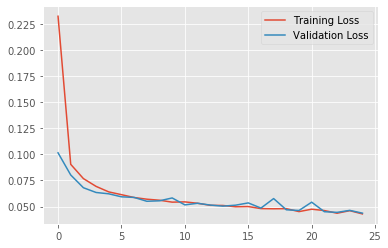

-------------------- Training Finished -------------------


In [23]:
print("------ Started training of the correspondence block ------")
torch.cuda.empty_cache()
train_correspondence_block(root_dir, classes, epochs=25, batch_size=5)
print("-------------------- Training Finished -------------------")

In [24]:
print("------ Started Initial pose estimation ------")
torch.cuda.empty_cache()
initial_pose_estimation(root_dir, classes, intrinsic_matrix)
print("------ Finished Initial pose estimation -----")

------ Started Initial pose estimation ------
0/3160 finished!
1000/3160 finished!
2000/3160 finished!
3000/3160 finished!
Number of instances where PnP couldn't be used:  55
------ Finished Initial pose estimation -----


In [25]:
print("----- Started creating inputs for DL based pose refinement ------")
create_refinement_inputs(root_dir, classes, intrinsic_matrix)
print("----- Finished creating inputs for DL based pose refinement -----")

----- Started creating inputs for DL based pose refinement ------
0/3160 finished!
1000/3160 finished!
2000/3160 finished!
3000/3160 finished!
Number of outliers:  6
----- Finished creating inputs for DL based pose refinement -----


In [21]:
print("----- Started training DL based pose refiner ------")
train_pose_refinement(root_dir, classes, epochs=10)
print("----- Finished training DL based pose refiner ------")

----- Started training DL based pose refiner ------
----- Epoch Number:  1 --------
Epoch: 1 	Training Loss: 41.385754 	Validation Loss: 54.485176
Validation loss decreased (inf --> 54.485176).  Saving model ...
----- Epoch Number:  2 --------
Epoch: 2 	Training Loss: 28.809266 	Validation Loss: 46.750640
Validation loss decreased (54.485176 --> 46.750640).  Saving model ...
----- Epoch Number:  3 --------
Epoch: 3 	Training Loss: 28.273817 	Validation Loss: 56.537318
----- Epoch Number:  4 --------
Epoch: 4 	Training Loss: 28.360586 	Validation Loss: 67.294473
----- Epoch Number:  5 --------
Epoch: 5 	Training Loss: 27.772457 	Validation Loss: 51.597067
----- Epoch Number:  6 --------
Epoch: 6 	Training Loss: 27.479509 	Validation Loss: 48.681757
----- Epoch Number:  7 --------
Epoch: 7 	Training Loss: 27.240248 	Validation Loss: 54.405298
----- Epoch Number:  8 --------
Epoch: 8 	Training Loss: 27.423427 	Validation Loss: 50.075631
----- Epoch Number:  9 --------
Epoch: 9 	Training L

## Evaluation

In [22]:
import copy
import time

parser = argparse.ArgumentParser(
    description='Script to create the Ground Truth masks')
parser.add_argument("--root_dir", default="LineMOD_Dataset/",
                    help="path to dataset directory")
args, unknown = parser.parse_known_args()

root_dir = args.root_dir

classes = {'ape': 1, 'benchviseblue': 2, 'cam': 3, 'can': 4, 'cat': 5, 'driller': 6,
           'duck': 7, 'eggbox': 8, 'glue': 9, 'holepuncher': 10, 'iron': 11, 'lamp': 12, 'phone': 13}

score_card = {'ape': 0, 'benchviseblue': 0, 'cam': 0, 'can': 0, 'cat': 0, 'driller': 0,
              'duck': 0, 'eggbox': 0, 'glue': 0, 'holepuncher': 0, 'iron': 0, 'lamp': 0, 'phone': 0}

instances = {'ape': 0, 'benchviseblue': 0, 'cam': 0, 'can': 0, 'cat': 0, 'driller': 0,
             'duck': 0, 'eggbox': 0, 'glue': 0, 'holepuncher': 0, 'iron': 0, 'lamp': 0, 'phone': 0}

transform = transforms.Compose([transforms.ToPILImage(mode=None),
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
fx = 572.41140
px = 325.26110
fy = 573.57043
py = 242.04899  # Intrinsic Parameters of the Camera
intrinsic_matrix = np.array([[fx, 0, px], [0, fy, py], [0, 0, 1]])

correspondence_block = UNet(n_channels=3, out_channels_id=14,
                                 out_channels_uv=256, bilinear=True)
# load the best weights from the training loop
correspondence_block.load_state_dict(torch.load(
    'correspondence_block.pt', map_location=torch.device('cpu')))
pose_refiner = Pose_Refiner()
# load the best weights from the training loop
pose_refiner.load_state_dict(torch.load(
    'pose_refiner.pt', map_location=torch.device('cpu')))

correspondence_block.cuda()
pose_refiner.cuda()
pose_refiner.eval()
correspondence_block.eval()

list_all_images = load_obj(root_dir + "all_images_adr")
testing_images_idx = load_obj(root_dir + "test_images_indices")

regex = re.compile(r'\d+')
upsampled = nn.Upsample(size=[240, 320], mode='bilinear', align_corners=False)
total_score = 0

try:
    os.mkdir("Evaluated_Images")
except FileExistsError:
    pass
start = time.time()

num_samples = 500

for i in range(500):

    img_adr = list_all_images[testing_images_idx[i]]
    label = os.path.split(os.path.split(os.path.dirname(img_adr))[0])[1]
    idx = regex.findall(os.path.split(img_adr)[1])[0]

    tra_adr = root_dir + label + "/data/tra" + str(idx) + ".tra"
    rot_adr = root_dir + label + "/data/rot" + str(idx) + ".rot"
    true_pose = get_rot_tra(rot_adr, tra_adr)

    test_img = cv2.imread(img_adr)
    img_for_bounding_box = copy.deepcopy(test_img)
    test_img = cv2.resize(
        test_img, (test_img.shape[1]//2, test_img.shape[0]//2), interpolation=cv2.INTER_AREA)

    test_img = torch.from_numpy(test_img).type(torch.double)
    test_img = test_img.transpose(1, 2).transpose(0, 1)

    if len(test_img.shape) != 4:
        test_img = test_img.view(
            1, test_img.shape[0], test_img.shape[1], test_img.shape[2])

    # pass through correspondence block
    idmask_pred, umask_pred, vmask_pred = correspondence_block(
        test_img.float().cuda())

    # convert the masks to 240,320 shape
    temp = torch.argmax(idmask_pred, dim=1).squeeze().cpu()
    upred = torch.argmax(umask_pred, dim=1).squeeze().cpu()
    vpred = torch.argmax(vmask_pred, dim=1).squeeze().cpu()
    coord_2d = (temp == classes[label]).nonzero(as_tuple=True)
    if coord_2d[0].nelement() != 0:  # label is detected in the image
        coord_2d = torch.cat((coord_2d[0].view(
            coord_2d[0].shape[0], 1), coord_2d[1].view(coord_2d[1].shape[0], 1)), 1)
        uvalues = upred[coord_2d[:, 0], coord_2d[:, 1]]
        vvalues = vpred[coord_2d[:, 0], coord_2d[:, 1]]
        dct_keys = torch.cat((uvalues.view(-1, 1), vvalues.view(-1, 1)), 1)
        dct_keys = tuple(dct_keys.numpy())
        dct = load_obj(root_dir + label + "/UV-XYZ_mapping")
        mapping_2d = []
        mapping_3d = []
        for count, (u, v) in enumerate(dct_keys):
            if (u, v) in dct:
                mapping_2d.append(np.array(coord_2d[count]))
                mapping_3d.append(dct[(u, v)])

        # PnP needs atleast 6 unique 2D-3D correspondences to run
        if len(mapping_2d) >= 6 or len(mapping_3d) >= 6:
            _, rvecs, tvecs, inliers = cv2.solvePnPRansac(np.array(mapping_3d, dtype=np.float32),
                                                          np.array(mapping_2d, dtype=np.float32), intrinsic_matrix, distCoeffs=None,
                                                          iterationsCount=150, reprojectionError=1.0, flags=cv2.SOLVEPNP_P3P)
            rot, _ = cv2.Rodrigues(rvecs, jacobian=None)
            pred_pose = np.append(rot, tvecs, axis=1)

        else:  # save an empty file
            pred_pose = np.zeros((3, 4))

        min_x = coord_2d[:, 0].min()
        max_x = coord_2d[:, 0].max()
        min_y = coord_2d[:, 1].min()
        max_y = coord_2d[:, 1].max()
        img = test_img.squeeze().transpose(1, 2).transpose(0, 2)
        obj_img = img[min_x:max_x+1, min_y:max_y+1, :]
        # saving in the correct format using upsampling
        obj_img = obj_img.transpose(0, 1).transpose(0, 2).unsqueeze(dim=0)
        obj_img = upsampled(obj_img)
        obj_img = obj_img.squeeze().transpose(0, 2).transpose(0, 1)
        obj_img = transform(torch.as_tensor(obj_img, dtype=torch.float32))
        # create rendering for an object
        cropped_rendered_img = create_rendering_eval(
            root_dir, intrinsic_matrix, label, pred_pose)
        rendered_img = torch.from_numpy(cropped_rendered_img)
        rendered_img = rendered_img.unsqueeze(dim=0)
        rendered_img = rendered_img.transpose(1, 3).transpose(2, 3)
        rendered_img = upsampled(rendered_img)
        rendered_img = rendered_img.squeeze()
        rendered_img = transform(torch.as_tensor(
            rendered_img, dtype=torch.float32))

        if len(rendered_img.shape) != 4:
            rendered_img = rendered_img.view(
                1, rendered_img.shape[0], rendered_img.shape[1], rendered_img.shape[2])

        if len(obj_img.shape) != 4:
            obj_img = obj_img.view(
                1, obj_img.shape[0], obj_img.shape[1],  obj_img.shape[2])
        pred_pose = (torch.from_numpy(pred_pose)).unsqueeze(0)

        # pose refinement to get final output
        xy, z, rot = pose_refiner(obj_img.float().cuda(),
                                  rendered_img.float().cuda(), pred_pose)
        # below 2 lines are for outliers only - edge case                          
        rot[torch.isnan(rot)] = 1  # take care of NaN and inf values
        rot[rot == float("Inf")] = 1
        xy[torch.isnan(xy)] = 0
        z[torch.isnan(z)] = 0
        # convert R quarternion to rotational matrix
        rot = (R.from_quat(rot.detach().cpu().numpy())).as_matrix()
        pred_pose = pred_pose.squeeze().numpy()
        # update predicted pose
        xy = xy.squeeze()
        pred_pose[0:3, 0:3] = rot
        pred_pose[0, 3] = xy[0]
        pred_pose[1, 3] = xy[1]
        pred_pose[2, 3] = z

        diameter = np.loadtxt(root_dir + label + "/distance.txt")
        ptcld_file = root_dir + label + "/object.xyz"
        pt_cld = np.loadtxt(ptcld_file, skiprows=1, usecols=(0, 1, 2))
        test_rendered = create_bounding_box(img_for_bounding_box, pred_pose, pt_cld, intrinsic_matrix)
        test_rendered = create_bounding_box(test_rendered, true_pose, pt_cld, intrinsic_matrix, color = (0,255,0))

        score = ADD_score(pt_cld, true_pose, pred_pose, diameter)
        float_score = ADD_score_norm(pt_cld, true_pose, pred_pose, diameter)
        path = "Evaluated_Images/" + str(float_score) + "_score_" + str(i) +'.png'
        cv2.imwrite(path, test_rendered)
        total_score += score
        score_card[label] += score

    else:
        score_card[label] += 0

    instances[label] += 1

print("Average Evaluation Time:", (time.time() - start)/num_samples)
print("ADD Score for all testing images is: ",total_score/num_samples)
float_score = [1 - score for score in float_score]
print("ADD float score for all testing images is:", sum(float_score)/num_samples)

<ipython-input-16-8b79ee6198a2>:13: RuntimeWarning: overflow encountered in true_divide
  coord_2D = homogenous_2D[:2, :] / homogenous_2D[2, :]


Average Evaluation Time: 0.9902797155380249
ADD Score for all testing images is:  0.316


TypeError: 'numpy.float64' object is not iterable

In [39]:
correspondence_block = UNet(
        n_channels=3, out_channels_id=14, out_channels_uv=256, bilinear=True)
correspondence_block.cuda()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [18]:
print(correspondence_block)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [22]:
import hiddenlayer as hl

transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]

In [50]:
fig = plt.figure()
hl.build_graph(correspondence_block, torch.zeros([1, 3, 640, 480]).cuda(), transforms).save("png")


<ipython-input-10-88b11db697d2>:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
<ipython-input-10-88b11db697d2>:58: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
<ipython-input-10-88b11db697d2>:59: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time yo

<Figure size 432x288 with 0 Axes>

In [41]:
from torchsummary import summary
summary(correspondence_block, (3, 640, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 640, 480]           1,792
       BatchNorm2d-2         [-1, 64, 640, 480]             128
              ReLU-3         [-1, 64, 640, 480]               0
            Conv2d-4         [-1, 64, 640, 480]          36,928
       BatchNorm2d-5         [-1, 64, 640, 480]             128
              ReLU-6         [-1, 64, 640, 480]               0
        DoubleConv-7         [-1, 64, 640, 480]               0
         MaxPool2d-8         [-1, 64, 320, 240]               0
            Conv2d-9        [-1, 128, 320, 240]          73,856
      BatchNorm2d-10        [-1, 128, 320, 240]             256
             ReLU-11        [-1, 128, 320, 240]               0
           Conv2d-12        [-1, 128, 320, 240]         147,584
      BatchNorm2d-13        [-1, 128, 320, 240]             256
             ReLU-14        [-1, 128, 3